# **Identifying Key Predictive Features and Health Inequities in Diabetes Risk: Gaining Insights from Machine Learning Models**

*Notebook by Sidney Christensen*

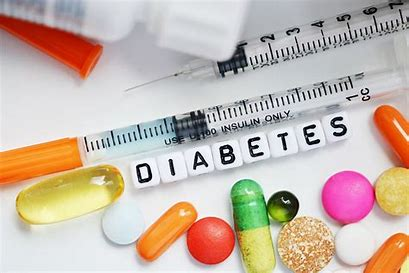

**Importing Libraries**

In [ ]:
!pip install shap

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats

# Data preprocessing and visualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt

# Model evaluation
from sklearn.metrics import classification_report, accuracy_score

# XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Hyperparameter optimization
from hyperopt import fmin, tpe, hp, STATUS_OK

# Deep Learning with TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1

#SHAP for feature importance evalutation using best model
import shap

**Read in data and explore five random samples**

In [ ]:
df = pd.read_csv("diabetes.csv")
df = df.drop('DoctorInCharge', axis=1)
df.sample(5)
#did sample instead to get five random samples

,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,SlowHealingSores,TinglingHandsFeet,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis
1111,7111,57,1,0,2,2,18.121501,1,4.123779,6.771090,...,0,0,65.172031,0,0,0,1.466772,9.670531,9.140915,1
1448,7448,58,0,0,0,1,24.012234,0,7.204598,3.678762,...,0,0,3.559523,0,0,1,1.049947,3.669313,3.652550,0
1326,7326,89,1,0,1,3,18.872695,0,18.729073,4.756138,...,0,0,11.147133,0,0,0,0.618890,6.289885,0.157574,1
807,6807,69,1,1,1,1,25.032132,0,3.145615,2.013042,...,0,0,18.788577,0,0,0,0.416277,9.076214,8.547259,1
270,6270,62,0,0,0,3,31.894466,1,6.735757,1.615032,...,0,0,43.014768,0,0,1,1.790720,3.861700,0.239124,1


# **Feature Description:**

PatientID: Unique identifier assigned to each patient (6000 to 7878)


# *Demographic Features:*

**Age:** ranges from 20 to 90 years

Gender: 0 represents Male and 1 represents Female

**Ethnicity:** Patient Ethnicity:

0: Caucasian,
1: African American,
2: Asian,
3: Other

**SocioeconomicStatus:** Socioeconomic status:

0: Low, 1: Middle, 2: High

**EducationLevel:** Education level:

0: None, 1: High School, 2: Bachelor's, 3: Higher


# *Lifestyle Factors*

**BMI:** Body Mass Index ranging from 15 to 40

**Smoking:** 0 = No and 1 = Yes

**AlcoholConsumption:** Weekly alcohol consumption in units, ranging from 0 to 20

**PhysicalActivity:** Weekly physical activity in hours, ranging from 0 to 10

**DietQuality:** Diet quality score, ranging from 0 to 10

**SleepQuality:** Sleep quality score, ranging from 4 to 10

# *Medical History*
**FamilyHistoryDiabetes:** 0 = No and 1 = Yes

**GestationalDiabetes:** History of gestational diabetes, where 0 = No and 1 = Yes

**PolycysticOvarySyndrome:** Presence of polycystic ovary syndrome, where 0 = No and 1 = Yes

**PreviousPreDiabetes:** History of previous pre-diabetes, where 0 = No and 1 = Yes

**Hypertension:** Presence of hypertension, where 0 = No and 1 = Yes

# *Clinical Measurements*

**SystolicBP:** Systolic blood pressure, ranging from 90 to 180 mmHg

**DiastolicBP:** Diastolic blood pressure, ranging from 60 to 120 mmHg

**FastingBloodSugar:** Fasting blood sugar levels, ranging from 70 to 200 mg/dL

**HbA1c:** Hemoglobin A1c levels, ranging from 4.0% to 10.0%

**SerumCreatinine:** Serum creatinine levels, ranging from 0.5 to 5.0 mg/dL

**BUNLevels:** Blood Urea Nitrogen levels, ranging from 5 to 50 mg/dL

**CholesterolTotal:** Total cholesterol levels, ranging from 150 to 300 mg/dL

**CholesterolLDL:** Low-density lipoprotein cholesterol levels, ranging from 50 to 200 mg/dL.

**CholesterolHDL:** High-density lipoprotein cholesterol levels, ranging from 20 to 100 mg/dL

**CholesterolTriglycerides:** Triglycerides levels, ranging from 50 to 400 mg/dL.
Medications

**AntihypertensiveMedications:** Use of antihypertensive medications, where 0 = No and 1 = Yes

**Statins:** Use of statins, where 0 = No and 1 = Yes

**AntidiabeticMedications:** Use of antidiabetic medications, where 0 = No and 1 = Yes

# *Symptoms and Quality of Life*

**FrequentUrination:** Presence of frequent urination, where 0 = No and 1 = Yes

**ExcessiveThirst:** Presence of excessive thirst, where 0 = No and 1 = Yes

**UnexplainedWeightLoss:** Presence of unexplained weight loss, where 0 = No and 1 = Yes

**FatigueLevels:** Fatigue levels, ranging from 0 to 10

**BlurredVision:** Presence of blurred vision, where 0 = No and 1 = Yes

**SlowHealingSores:** Presence of slow-healing sores, where 0 = No and 1 = Yes

**TinglingHandsFeet:** Presence of tingling in hands or feet, where 0 = No and 1 = Yes

**QualityOfLifeScore:** Quality of life score, ranging from 0 to 100

# *Environmental and Occupational Exposures*

**HeavyMetalsExposure:** Exposure to heavy metals, where 0 = No and 1 = Yes

OccupationalExposureChemicals: Occupational exposure to harmful chemicals, where 0 = No and 1 = Yes

WaterQuality: Quality of water, where 0 = Good and 1 = Poor

# *Health Behaviors*

**MedicalCheckupsFrequency:** Frequency of medical check-ups per year, ranging from 0 to 4

**MedicationAdherence:** Medication adherence score, ranging from 0 to 10

**HealthLiteracy:** Health literacy score, ranging from 0 to 10

# *Diagnosis Information ( Target Variable)*

**Diagnosis:** Diagnosis status for Diabetes, where 0 = No and 1 = Yes



**Get summary of feature info/types**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879 entries, 0 to 1878
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PatientID                      1879 non-null   int64  
 1   Age                            1879 non-null   int64  
 2   Gender                         1879 non-null   int64  
 3   Ethnicity                      1879 non-null   int64  
 4   SocioeconomicStatus            1879 non-null   int64  
 5   EducationLevel                 1879 non-null   int64  
 6   BMI                            1879 non-null   float64
 7   Smoking                        1879 non-null   int64  
 8   AlcoholConsumption             1879 non-null   float64
 9   PhysicalActivity               1879 non-null   float64
 10  DietQuality                    1879 non-null   float64
 11  SleepQuality                   1879 non-null   float64
 12  FamilyHistoryDiabetes          1879 non-null   i

As you can see, we have 43 features (not counting ID, DoctorInCharge, & Diagnosis columns) and 1879 patients. Let us first check for missing data, and then perform some exploratory data analysis to better understand what each variable looks like within the population!

In [ ]:
print("Number of Missing Values:",
      df.isnull().sum().sum())

Number of Missing Values: 0


No missing values!

In [ ]:
categorical_variables = df[[
    'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'Smoking',
    'FamilyHistoryDiabetes', 'GestationalDiabetes', 'PolycysticOvarySyndrome',
    'PreviousPreDiabetes', 'Hypertension', 'AntihypertensiveMedications',
    'Statins', 'AntidiabeticMedications', 'FrequentUrination', 'ExcessiveThirst',
    'UnexplainedWeightLoss', 'BlurredVision', 'SlowHealingSores',
    'TinglingHandsFeet', 'HeavyMetalsExposure', 'OccupationalExposureChemicals',
    'WaterQuality', 'Diagnosis'
]]

In [ ]:
continuous_variables = df[[
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c',
    'SerumCreatinine', 'BUNLevels', 'CholesterolTotal', 'CholesterolLDL',
    'CholesterolHDL', 'CholesterolTriglycerides', 'FatigueLevels',
    'QualityOfLifeScore', 'MedicalCheckupsFrequency', 'MedicationAdherence',
    'HealthLiteracy'
]]

In [ ]:
continuous_variables.describe()

,Age,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,SystolicBP,DiastolicBP,FastingBloodSugar,HbA1c,...,BUNLevels,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,FatigueLevels,QualityOfLifeScore,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,...,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,55.043108,27.687601,10.096587,5.200790,4.895801,7.021328,134.050559,89.863757,135.204490,6.976133,...,27.798153,225.006464,124.656831,60.060944,227.386167,4.949003,48.508643,1.997101,4.957539,5.011736
std,20.515839,7.190975,5.914216,2.857012,2.867144,1.729469,25.613830,17.328086,37.515750,1.739365,...,12.800797,43.367170,42.911145,23.316682,101.071578,2.884483,28.758488,1.122632,2.910934,2.920908
min,20.000000,15.025898,0.000928,0.004089,0.000885,4.004336,90.000000,60.000000,70.074649,4.003089,...,5.010401,150.056094,50.058252,20.014494,50.154649,0.004977,0.002390,0.004013,0.005384,0.000362
25%,38.000000,21.469981,4.789725,2.751022,2.476802,5.481789,112.000000,75.000000,102.341470,5.443856,...,17.172009,186.933051,87.810946,40.011963,140.873930,2.417748,23.974098,1.057801,2.420024,2.410113
50%,55.000000,27.722988,10.173865,5.249002,4.888566,7.094692,134.000000,90.000000,137.398241,7.095732,...,28.190147,225.120112,124.918023,60.456988,228.417429,4.851914,47.519693,1.987170,4.843886,5.035208
75%,73.000000,33.856460,15.285359,7.671402,7.356058,8.523814,156.000000,105.000000,167.362362,8.423211,...,38.506299,263.529424,161.624444,80.059112,313.408944,7.569772,72.883179,2.946019,7.513933,7.586865
max,90.000000,39.998811,19.996231,9.993893,9.998677,9.989372,179.000000,119.000000,199.935506,9.991193,...,49.975728,299.998480,199.898732,99.958394,399.885928,9.999979,99.788530,3.999715,9.997165,9.993029


Checking for Outliers within our continuous variables using z-score

In [ ]:
# Calculate z-scores for all values
z_scores = np.abs(stats.zscore(continuous_variables))

threshold = 3
outliers = (z_scores > threshold).any(axis = 1)

print(continuous_variables[outliers])

Empty DataFrame
Columns: [Age, BMI, AlcoholConsumption, PhysicalActivity, DietQuality, SleepQuality, SystolicBP, DiastolicBP, FastingBloodSugar, HbA1c, SerumCreatinine, BUNLevels, CholesterolTotal, CholesterolLDL, CholesterolHDL, CholesterolTriglycerides, FatigueLevels, QualityOfLifeScore, MedicalCheckupsFrequency, MedicationAdherence, HealthLiteracy]
Index: []

[0 rows x 21 columns]


no outliers!

Checking for Class Imbalance

<ipython-input-32-596487640f2f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diagnosis', data = df, palette = 'seismic')


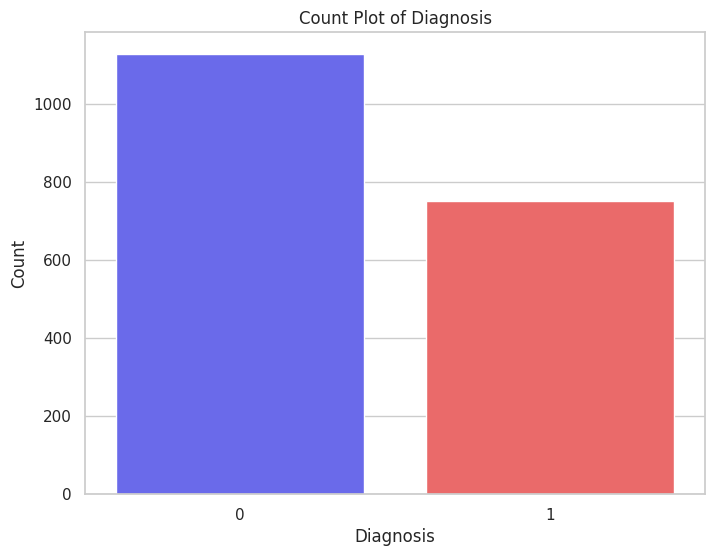

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize = (8, 6))
sns.countplot(x='Diagnosis', data = df, palette = 'seismic')
plt.title('Count Plot of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

Since class imbalance is present, I will mitigate its effects through each individual model instead, as I want to learn how to address it within the model. I already learned how to use SMOTE in another project and want to optimize how much I learn through these projects:).

# Machine Learning Models



*General Note about optimization methods used in this project:*

**Manual Search, Random Search, Grid Search, and Bayesian Optimization** are generally the four methods used to find the best parameters for machine elarning algorithms, including the ones used in this project. To demonstrate experience with and understanding of them, I used Random Search for the Random Forest and Grid Search & Bayesian Optimization for the XGB. It was very fun being able to implement them and understand how they work/differ!

# **Random Forest**

An **ensemble learning method** that constructs **multiple decision trees** and combines their outputs to improve accuracy and robustness. The Random Forest method builds many trees **independently in parallel**. The final prediction is amde by averaging the predictions of all the trees (regression) but in our case, since we are dealing with binary classification, **majority voting** is used.

Random forests use many independent decision trees (with randomly selected features). **Boot strapping** is then used to create different subsets of the data with replacement which makes the model more robust (here, our random search chooses an optimal set of parameters in which bootstrapping is NOT necessary, however I still wanted to demonstrate my knowledge of how it works)

First, we need to one-hot encode our categorical variables

In [ ]:
encoded_categorical_data = pd.get_dummies(categorical_variables)

data = pd.concat([continuous_variables,
                  encoded_categorical_data], axis = 1)

Building the model

In [ ]:
X = data.drop('Diagnosis', axis = 1)
y = data['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
n_estimators = [100, 200, 300]

max_features = ['log2', 'sqrt']

max_depth = [5, 10, 15, 20, 25, 30]

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

BootStrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': BootStrap}

print(random_grid)

{'n_estimators': [100, 200, 300], 'max_features': ['log2', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


# Bootstrapping

In this random grid, I also allow for the search to include the statistical technique of **"Bootstrapping"**, a common tool used to ensure **reduced variance** and **improved robustness to outliers/noise** in a plethora of machine learning algorithms **AND** statistical methods.

**Bootstrapping:** Bootstrapping in Random Forests involves **creating multiple subsets of the original training dataset by sampling with replacement.** Each of these subsets, called **bootstrap sample**s, is used to **train individual decision trees**. This method ensures that each tree is trained on a slightly different dataset, promoting **diversity among the trees**. The final prediction of the Random Forest is made by aggregating the predictions of all the individual trees, typically using **majority voting for classification** or **averaging for regression**, which helps to **reduce overfitting** and **improve the model's generalization** performance.

Let me note here as well that a random forest that uses bootstrapping is a form of **bagging**- short for **bootstrap aggregation** (also classified as an ensemble method). If the search finds the best set of parameters to also utilize bootstrapping, then the random forest will utilize random subsets of the data for each tree. When majority voting is used to **aggreagate all of the individual decision tree outcomes** (since we are dealing with binary classification), this is the implementation of bagging!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#addressing class imbalance
rf = RandomForestClassifier(class_weight = 'balanced')

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, scoring = 'accuracy', verbose=2, random_state=42, n_jobs = -1)

**Model with Random Search**

Random Search is a variation of grid search that randomly samples different hyperparameter combinations to try instead of going through all of them. Usually I do grid search, so this was a fun alternative method to use!

In [ ]:
np.random.seed(42)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}


In [ ]:
best_params = {
    'n_estimators': 200,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 5,
    'bootstrap': False
}

In [ ]:
rf_random_best = RandomForestClassifier(**best_params, random_state = 42)

# Fit the model on your training data
rf_random_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200, random_state=42)

**Base Model**

In [ ]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
base_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Evaluation**

In [ ]:
y_pred_1 = rf_random_best.predict(X_test)

random_report = classification_report(y_test, y_pred_1)
print("Random Search Model:\n", random_report)

y_pred_2 = base_model.predict(X_test)

base_report = classification_report(y_test, y_pred_2)
print("Base Model:\n", base_report)


Random Search Model:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       233
           1       0.95      0.80      0.87       143

    accuracy                           0.91       376
   macro avg       0.92      0.89      0.90       376
weighted avg       0.91      0.91      0.91       376

Base Model:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       233
           1       0.95      0.81      0.88       143

    accuracy                           0.91       376
   macro avg       0.92      0.89      0.90       376
weighted avg       0.92      0.91      0.91       376



As we can see, there is a minimal difference between the base model and the random grid search model. Since the base model has a slightly better f1 score and recall for a positive diagnosis (class = 1), the base model is actually preferred. In general, whatever less is more in machine learning. If a base model is performing as well as or better than a more computationally expensive/complex model, the base model is preferred!

# **XGBoost**

An **ensemble method** like random forests, XGBoost uses multiple decision trees **sequentially** with each new tree correcting the previous errors of the combined earlier models but one step at a time. The trees are combined in a weighted manner to form a single strong model. XGBoost uses boosting, meaning it **combines weak learners sequentially** so that **each new tree corrects the errors of the previous one**.

For multiclass classification, cross entropy is a popular choice. In our case we will use **log loss for binary classification**.

We want the loss of the next tree to be such that it lowers the loss compared to the first tree alone. Mathematically speaking, we are **fitting the next tree to the gradient of the loss function with respect to the output of the previous model.**

As stated earlier, this is a algorithms uses **SEQUENTIALLY trained models** (here we are using decision trees), and so this is how bagging and boosting differ. Boosting **gradually improves predictions** and **reduces bias** one model at a time whereas bagging uses multiple models equally to arrive at a final prediction. Keep reading for a deeper explanation of boosting!

# Boosting

Boosting is an ensemble learning technique that sequentially combines weak learners, typically decision trees, to create a strong predictive model. It iteratively trains models where each subsequent model corrects the errors of its predecessor by focusing on instances that were previously misclassified. Boosting assigns higher weights to misclassified instances, allowing subsequent models to prioritize learning from challenging cases. The final prediction is a weighted combination of predictions from all weak learners, often resulting in improved accuracy and robustness compared to individual models.

**Optimization using Grid Search**

In [ ]:
param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.1, 0.01, 0.0001],
    'subsample': [0.5, 0.7, 1]
}

#addressing class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = xgb.XGBClassifier(scale_pos_weight = scale_pos_weight)

#this gives more weight to the positive classes since they are the minority class. So, when the model uses this weight in the loss function giving more attention to the minority class. Class imbalance
#is an important and very common issue to address in medical data as the degree of prevalence is almost never balanced.

grid_search = GridSearchCV(xgb_model, param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'learning_rate': 0.01, 'max_depth': 7, 'subsample': 1}


In [ ]:
np.random.seed(42)

Grid_Best_Params = {'learning_rate': 0.01,
                    'max_depth': 7,
                    'subsample': 1}

xgb_model = xgb.XGBClassifier(**Grid_Best_Params, scale_pos_weight = scale_pos_weight, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

grid_report = classification_report(y_test, y_pred)
print(grid_report)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       233
           1       0.93      0.85      0.89       143

    accuracy                           0.92       376
   macro avg       0.92      0.90      0.91       376
weighted avg       0.92      0.92      0.92       376



**Bayesian Optimization**

Bayesian Optimization finds the best hyperparameters by learning from previous results, making it more efficient than random and grid search. It balances exploration (trying new things) with exploitation (using what works best so far), improving search efficiency. However, it's more computationally intensive. Unlike random and grid search, Bayesian Optimization uses past evaluations to guide its search, learning from successes and failures to suggest better hyperparameter choices. It builds a predictive model based on these evaluations (called the objective function), using it to decide the next set of hyperparameters to try. This iterative process continues until it finds the optimal settings or reaches a stopping point.

In [ ]:
np.random.seed(42)

search_space = {
    'max_depth': hp.choice('max_depth', [2,3,4, 5, 6, 7, 8,9,10,11]),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

#function we want to minimize

def function(params):
  xgb_model = xgb.XGBClassifier(**params, scale_pos_weight = scale_pos_weight, random_state = 42)
  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  return {'loss': -score, 'status': STATUS_OK}

best_params = fmin(function, search_space, algo = tpe.suggest, max_evals = 100)
print("Best parameters: ", best_params)


100%|██████████| 100/100 [00:59<00:00,  1.68trial/s, best loss: -0.9414893617021277]
Best parameters:  {'learning_rate': 0.07608993102557117, 'max_depth': 1, 'subsample': 0.7090223139513929}


*please ignore the best parameters above. The bayesian optimization previously found the parameters below to be the best parameters and I kept those since they gave me the best classification report metrics!*

In [ ]:
np.random.seed(42)

Bayesian_Best_Params = {'learning_rate': 0.007069846110715823, 'max_depth': 8, 'subsample': 0.8077209376654677}

xgb_model = xgb.XGBClassifier(**Bayesian_Best_Params, scale_pos_weight = scale_pos_weight, random_state = 42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

bayes_report = classification_report(y_test, y_pred)
print(bayes_report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       233
           1       0.95      0.88      0.91       143

    accuracy                           0.94       376
   macro avg       0.94      0.93      0.93       376
weighted avg       0.94      0.94      0.94       376



Cool! Bayesian Optimization gave us 2% better accuracy, as well as all slightly better precision, recall and fl-scores!

# **Deep Learning (Feed Forward Neural Network)**

**Feed Forward Neural Network(FFNN)** using simple forward propogation (input -> hidden layers where tranformations occur (activation/dropout) -> output layer

--------------------------------------------------------------------------------

Layer type: **Dense**

Dense layers are layers in which every neuron in that layer receives input (is connected to) every neuron in the previous layer.

--------------------------------------------------------------------------------

Regularization Technique: **Dropout**

Dropout is a **regularization technique** used in neural networks to **mitigate overfitting** by **randomly deactivating neurons** during **training**. When a mini-batch of data is processed, Dropout **independently selects a subset of neurons in each specified layer** and **sets their outputs to zero**, according to the dropout rate specified (e.g., 0.5 for 50% dropout). This stochastic dropout process **prevents neurons from becoming overly dependent on specific features** in the training data, encouraging the network to **learn more generalized representations**. By reducing the co-adaptation of neurons to the training set, Dropout **enhances the model's ability to generalize** to new, unseen data, thus improving its overall performance and robustness in various machine learning tasks.

--------------------------------------------------------------------------------

**Early stopping** is a callback technique in machine learning where the **training** of a model is **halted prematurely** based on its performance on a validation dataset. By monitoring metrics like **accuracy or loss** on the validation set during training, early stopping **aims to prevent overfitting**. It stops training when the model's performance on the validation data **stops improving**, thus ensuring **better generalization** to new, unseen data and **optimizing training efficiency**.

If **patience** = 3 (like we use in this NN), the training will stop if the accuracy on the validation set does not improve after three epochs. You can also use accuracy instead of val_loss, but here I chose val_loss.

--------------------------------------------------------------------------------

In [ ]:
encoded_categorical_data = pd.get_dummies(categorical_variables)

data = pd.concat([continuous_variables, encoded_categorical_data], axis = 1)

X = data.drop('Diagnosis', axis = 1)
y = data['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

scaler = StandardScaler()
columns_to_scale = continuous_variables.columns

print(columns_to_scale)

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scaler.fit_transform(X_val[columns_to_scale])
X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

Index(['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar',
       'HbA1c', 'SerumCreatinine', 'BUNLevels', 'CholesterolTotal',
       'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
       'FatigueLevels', 'QualityOfLifeScore', 'MedicalCheckupsFrequency',
       'MedicationAdherence', 'HealthLiteracy'],
      dtype='object')


In [ ]:
NN = Sequential()

#input layer
NN.add(Dense(256, input_dim = X_train.shape[1], activation = 'relu', kernel_regularizer=l1(0.01)))

#hidden layers
NN.add(Dense(256, activation= 'relu', kernel_regularizer=l1(0.001)))
NN.add(Dropout(0.5))

NN.add(Dense(128, activation= 'relu', kernel_regularizer=l1(0.001)))
NN.add(Dropout(0.5))

NN.add(Dense(64, activation = 'relu', kernel_regularizer=l1(0.001)))

#output layer
NN.add(Dense(1, activation = 'sigmoid'))

#compile the model
NN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

#model summary
NN.summary()

history = NN.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

#evaluate model
loss, accuracy = NN.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          11,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,273 (462.00 KB)

 Trainable params: 118,273 (462.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5848 - loss: 13.2770 - val_accuracy: 0.5880 - val_loss: 9.2298
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6542 - loss: 8.0879 - val_accuracy: 0.7708 - val_loss: 5.0227
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7734 - loss: 4.2698 - val_accuracy: 0.8173 - val_loss: 2.4413
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8053 - loss: 2.1141 - val_accuracy: 0.8372 - val_loss: 1.3712
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8087 - loss: 1.2842 - val_accuracy: 0.8372 - val_loss: 0.9946
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8342 - loss: 0.9585 - val_accuracy: 0.8405 - val_loss: 0.8208
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8439 - loss: 0.8131 - val_accuracy: 0.8439 - val_loss: 0.7392
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8663 - loss: 0.7258 - val_accuracy: 0.8671 - val_lo

In [ ]:
y_pred_prob = NN.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

NN_report = classification_report(y_test, y_pred)
print("FFNN classification report:", NN_report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FFNN classification report:               precision    recall  f1-score   support

           0       0.89      0.87      0.88       233
           1       0.79      0.83      0.81       143

    accuracy                           0.85       376
   macro avg       0.84      0.85      0.85       376
weighted avg       0.86      0.85      0.85       376



Not bad! However, all three of our previous models gave an accuracy in the 90%-100% range.

# **Choosing the Best Model**

After comparing the evaluation metrics of all models, the **XGBoost** model using **Bayesian Optimization** is the best model. It has the best accuracy, recall, precision and F1 scores across all five of the models. I wont take computational expense into account as none of these models took particularly long to train. The only process that took about 10 minutes was the random grid search for the random forest.

Let us also acknowledge the domain of our data. Diagnosing any disease/condition is a careful process, one that can't simply be a guessing game. Here, we attempt to build machine learning models that can predict the diagnosis of a patient.

This in mind, it important we **minimize false negatives**. In this context it means diagnosing a patient as nondiabetic when truly they are diabetic. The XGBoost with Bayesian Optimization exhibits a recall of .87 for patients with Diabetes. Since a higher recall means less false negatives, we want to prioritize this evaluation metric.

**False Negatives = (true positives / recall) - true positives**

This can be absolutely detrimental to the patient's health as they would not receive the proper medical treatment. It is crucial to understand that while ML can be used to build models able to make predictions as well as a doctor would, further medical intervention/testing should always be used to confirm the status of a patient's heath.

# **Using Shapley Additive Explanations (SHAP) to understand feature importance** (based on best model: XGBoost using Bayesian Optimization)

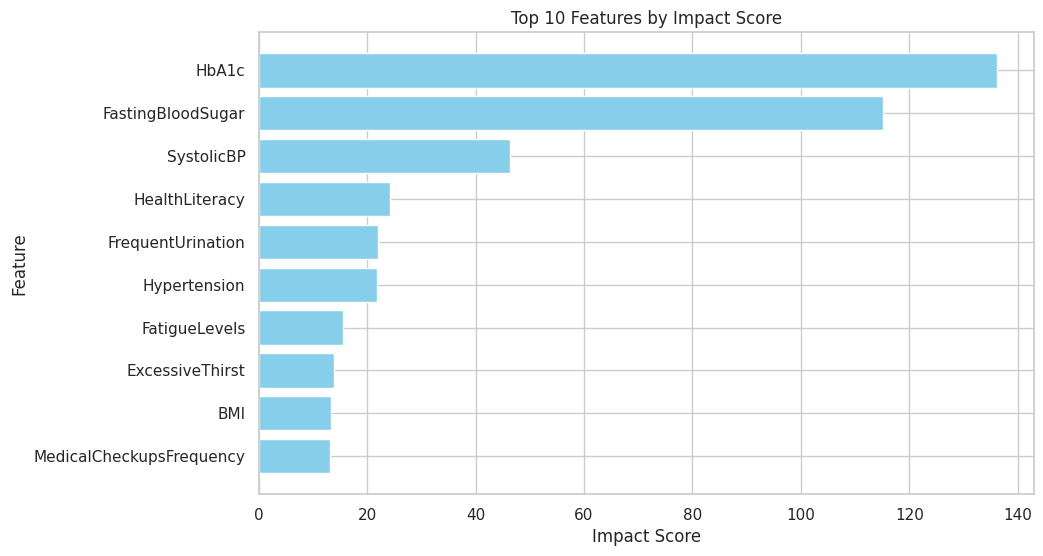

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)

shap_values_abs = np.abs(shap_values_df)
aggregated_impact_scores = shap_values_abs.sum(axis=0)

impact_score_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Impact Score': aggregated_impact_scores
})

top_features = impact_score_df.sort_values(by='Impact Score', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Impact Score'], color='skyblue')
plt.xlabel('Impact Score')
plt.ylabel('Feature')
plt.title('Top 10 Features by Impact Score')
plt.gca().invert_yaxis()  #invert y-axis to show the feature with the highest score at the top
plt.show()

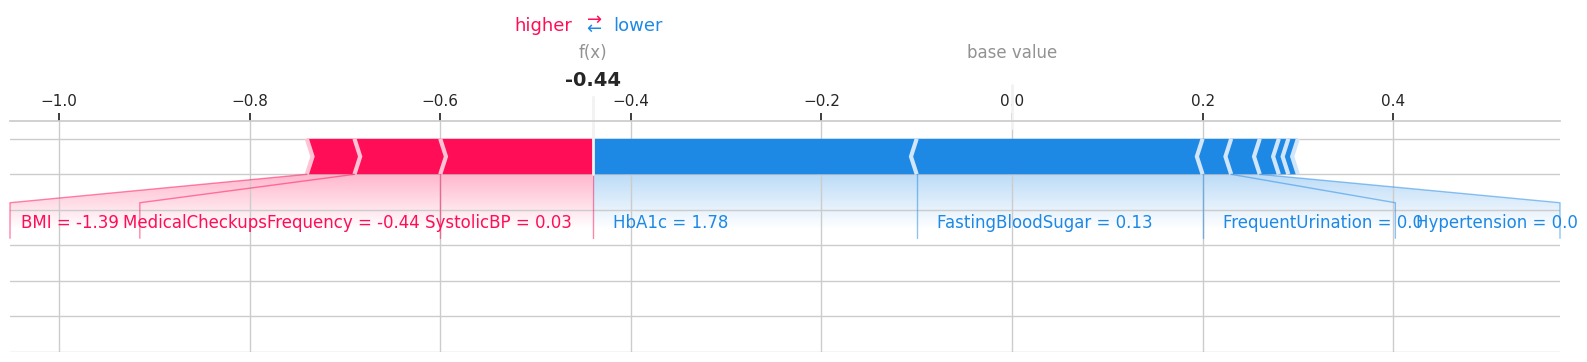

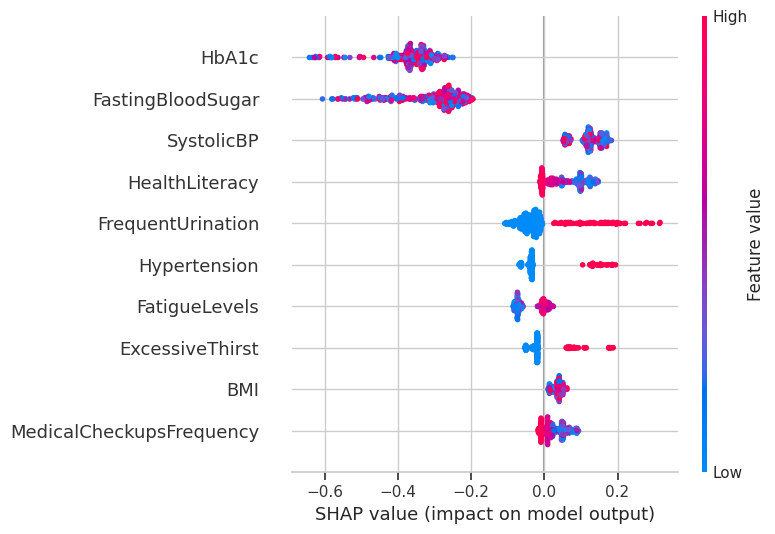

In [ ]:
#filter SHAP values to include only the top 10 features
top_feature_names = top_features['Feature'].tolist()
filtered_shap_values_df = shap_values_df[top_feature_names]

filtered_shap_values = np.array(filtered_shap_values_df)

filtered_X_test = X_test[top_feature_names]
explanation = shap.Explanation(values=filtered_shap_values,
                               base_values=np.full(filtered_shap_values.shape[0], explainer.expected_value),
                               data=filtered_X_test)

#force plot
shap.force_plot(np.round(explanation.base_values[0],2), np.round(explanation.values[0],2), np.round(explanation.data.iloc[0], 2), matplotlib=True)
plt.show()

#summary plot
shap.summary_plot(filtered_shap_values, filtered_X_test)
plt.show()

# **Impact Scores:**

It is no surprise that the top ten features are as shown. However, this chart proves that the model is trustworthy in that it has identified many of the main conditions and symptoms commonly associated with diabetes.

Looking at the chart, I want to dive deeper into health literacy and medical check ups frequency. This impact score chart has helped us identify which health inequities this population faces and how to explore possible solutions to them. (**More on this in the conclusion and "What's Next?" sections**)

# **Force Plot Interpretation:**

Each feature's SHAP value is shown as a bar or arrow in the plot. The length and direction of these bars or arrows represent the magnitude and impact of each feature on the prediction. (this plot uses the first observation)

Here, the base value is -.44. This is a log-odds value that we can translate into a probability using the logistic function 1/(1+e^-(-.44) = .39

An arrow pointing right (toward the positive side) means that feature increases the prediction, while an arrow pointing left (toward the negative side) means it decreases the prediction.

When the model was making a prediction on this particular observation, Hemoglobin A1C, fasting blood sugar, systolic blood pressure and the frequency of which the patient has medical checkups were the features most significant in predicting their likelihood of having diabetes.

# **Summary Plot Interpretation:**

We can see for a noticeable amount of instances that a lesser value of health literacy increases likelihood of having diabetes

Increased levels of frequent urination, hypertension and excessive thirst also increases patient's likelihood of having diabetes

We can also see that having less frequent medical checkups increases patient's likelihood of having diabetes

These interpretations of the summary plot not only confirm the validity of the model (since it has learned the most common symptoms of diabetes), but also provide insight into what other features in this vast dataset may need to be explored further through statistical analysis (I have alreyd suggested Health Literacy and Frequency of Medical Checkups, so this supports this suggestion).

# **Conclusion**

The purpose of this project was to build a reliable machine learning model, and use it to:

1) Understand which types of features were most significant in its decision making

2) Create an impact score for each feature to suggest to researchers and analysts which features we may be overlooking and which to further evaluate through statistical analysis.

The features to consider further using these methods are: Health Literacy and Medical Checkups Frequency.

# **What's Next?**

My next step is to gather data on the factors influencing health literacy and access to medical checkups, particularly in populations that face challenges in obtaining either. From there, we can conduct an in-depth statistical analysis to propose solutions that improve health literacy and access to medical checkups, tailored to address the specific barriers faced by these populations.